Set Shots - Expected Miss Model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import set_shots_file_path
# from total_points_model.domain.preprocessing.data_preprocessor import DataPreprocessor
# from total_points_model.domain.contracts.mappings import Mappings
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [20]:
new_version = 2
model_name = "expected_miss_set"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [21]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [45]:
RESPONSE = ModellingDataContract.RESPONSE_MISS

Features

In [46]:
FEATURES = ModellingDataContract.set_goal_modelling_feature_list

Load Data

In [47]:
df_modelling = pd.read_csv(set_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Miss,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
11052,208,possGain,behind,1663.0,4,634,683.0,Geelong,Geelong,Tom Hawkins,Tom_Hawkins,Kick,41.0,25.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,0,1,1,0,105.0,32.0,73.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,48.0,48.0,26.0,25.0,21.0,21.0,14.0,683.0,644.0,642.0,641.0,49.0,39.0,8.062258,39.0,25.0,46.324939,0.570040,32.660913,0.116867,6.695990,0.364585,20.889203,1521.0,3.663562,True,43,True
11053,212,kickIn,goal,1730.0,4,787,885.0,Geelong,Geelong,Patrick Dangerfield,Patrick_Dangerfield,Kick,51.0,43.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,107.0,33.0,74.0,Kick,Contested Mark,Contest Target,Kick Inside 50 Result,51.0,53.0,53.0,53.0,43.0,38.0,38.0,38.0,885.0,852.0,851.0,850.0,98.0,33.0,5.385165,29.0,43.0,51.865210,0.977446,56.003541,0.069260,3.968302,0.214332,12.280314,841.0,3.367296,True,29,True
11054,213,centreBounce,goal,1754.0,4,956,979.0,Sydney,Sydney,Paddy McCartin,Paddy_McCartin,Kick,66.0,0.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,0,6,119.0,33.0,86.0,Kick,Free For,Kick Inside 50 Result,Kick Into F50,66.0,74.0,74.0,27.0,0.0,0.0,0.0,17.0,979.0,977.0,968.0,967.0,23.0,2.0,8.000000,14.0,0.0,14.000000,0.000000,0.000000,0.482343,27.636207,2.588598,148.315731,196.0,2.639057,True,78,True
11055,219,centreBounce,goal,1846.0,4,1252,1266.0,Sydney,Sydney,Chad Warner,Chad_Warner,Kick,26.0,3.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,0,6,125.0,39.0,86.0,Kick,Uncontested Mark,Ground Kick,Handball,26.0,18.0,-5.0,-2.0,3.0,2.0,-4.0,3.0,1266.0,1265.0,1264.0,1260.0,14.0,1.0,8.062258,54.0,3.0,54.083269,0.055499,3.179830,0.118569,6.793500,0.365993,20.969862,2916.0,3.988984,True,53,True
11056,228,centreBounce,goal,1912.0,4,1519,1560.0,Geelong,Geelong,Jeremy Cameron,Jeremy_Cameron,Kick,41.0,21.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,131.0,45.0,86.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,49.0,49.0,25.0,21.0,17.0,17.0,33.0,1560.0,1535.0,1532.0,1531.0,41.0,25.0,8.944272,39.0,21.0,44.294469,0.493941,28.300756,0.127885,7.327246,0.400462,22.944787,1521.0,3.663562,True,66,True


In [48]:
df_modelling[['ballUp', 'centreBounce', 'kickIn', 'possGain', 'throwIn']] = pd.get_dummies(df_modelling['Initial_State'])

In [49]:
training_data = df_modelling[df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]
test_data = df_modelling[~df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]

In [50]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]

In [51]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter,ballUp,centreBounce,kickIn,possGain,throwIn
11,122,possGain,goal,1074.0,3,28,72.0,Sydney,Sydney,Nick Blakey,Nick_Blakey,Kick,28.0,-14.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,51.0,52.0,-1.0,Kick,Uncontested Mark,Kick Inside 50 Result,Kick Into F50,28.0,35.0,35.0,32.0,-14.0,-12.0,-12.0,35.0,72.0,38.0,36.0,36.0,44.0,34.0,7.280110,50.0,14.0,51.923020,0.273009,15.642246,0.119147,6.826615,0.368686,21.124166,2500.0,3.912023,True,83,False,0,0,0,1,0
12,132,possGain,goal,1168.0,3,422,469.0,Sydney,Sydney,Logan McDonald,Logan_McDonald,Kick,47.0,-4.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,57.0,58.0,-1.0,Kick,Mark On Lead,Kick,Gather,47.0,55.0,30.0,22.0,-4.0,-4.0,2.0,6.0,469.0,434.0,432.0,430.0,47.0,35.0,8.000000,31.0,4.0,31.256999,0.128323,7.352379,0.205222,11.758330,0.672664,38.540807,961.0,3.433987,True,93,False,0,0,0,1,0
15,144,throwIn,goal,1283.0,3,1014,1041.0,Sydney,Sydney,Callum Mills,Callum_Mills,Kick,29.0,-3.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,58.0,71.0,-13.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,29.0,37.0,37.0,22.0,-3.0,-2.0,-2.0,-16.0,1041.0,1019.0,1018.0,1017.0,27.0,22.0,8.062258,49.0,3.0,49.091751,0.061148,3.503532,0.130680,7.487397,0.405895,23.256079,2401.0,3.891820,True,99,False,0,0,0,0,1
20,194,throwIn,goal,1678.0,4,589,654.0,Sydney,Sydney,Luke Parker,Luke_Parker,Kick,49.0,-43.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,71.0,107.0,-36.0,Kick,Uncontested Mark,Kick Inside 50 Result,Kick Into F50,49.0,53.0,53.0,7.0,-43.0,-40.0,-40.0,-51.0,654.0,624.0,622.0,621.0,65.0,30.0,5.000000,29.0,43.0,51.865210,0.977446,56.003541,0.069260,3.968302,0.214332,12.280314,841.0,3.367296,True,96,False,0,0,0,0,1
31,84,centreBounce,goal,676.0,2,418,472.0,Western Bulldogs,Western Bulldogs,Lachlan McNeil,Lachlan_McNeil,Kick,71.0,0.0,effective,True,NaN,141,160,Collingwood,Western Bulldogs,right,202101_Collingwood_WesternBulldogs,202101,2021,1,0,6,0,6,14.0,26.0,-12.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,71.0,42.0,42.0,7.0,0.0,-21.0,-21.0,-20.0,472.0,430.0,428.0,427.0,54.0,42.0,35.805028,9.0,0.0,9.000000,0.000000,0.000000,0.814019,46.639866,-15.483871,-887.160457,81.0,2.197225,True,95,False,0,1,0,0,0


Preprocess Data

In [52]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [53]:
X_train_preproc = X_train[ModellingDataContract.set_goal_modelling_feature_list]
X_test_preproc = X_test[ModellingDataContract.set_goal_modelling_feature_list]

In [54]:
X_train_preproc.shape, X_test_preproc.shape

((8749, 9), (2308, 9))

In [55]:
X_train_preproc.head()

,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn
0,46.0,52.009614,0.908067,0.075999,0,0,1,0,0
1,52.0,43.600459,0.931882,0.088007,0,0,0,1,0
2,45.0,36.674242,0.451453,0.158231,0,0,0,1,0
3,59.0,33.015148,0.957589,0.112618,0,0,0,0,1
4,33.0,46.572524,0.260602,0.133410,0,1,0,0,0


In [56]:
X_test_preproc.head()

,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn
11,28.0,51.923020,0.273009,0.119147,0,0,0,1,0
12,47.0,31.256999,0.128323,0.205222,0,0,0,1,0
15,29.0,49.091751,0.061148,0.130680,0,0,0,0,1
20,49.0,51.865210,0.977446,0.069260,0,0,0,0,1
31,71.0,9.000000,0.000000,0.814019,0,1,0,0,0


Load Model

In [57]:
xgb_model = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

Get Predictions

In [58]:
train_preds = xgb_model.predict(X_train_preproc)
test_preds = xgb_model.predict(X_test_preproc)

In [59]:
train_probas = xgb_model.predict_proba(X_train_preproc)[:, 1]
test_probas = xgb_model.predict_proba(X_test_preproc)[:, 1]

Compare Model

In [60]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [61]:
compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
                                                          'xgb_probas':'old_probas'})
compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
                                                        'xgb_probas':'old_probas'})


In [62]:
training_data.shape, compare_train_data.shape

((8749, 72), (8749, 8))

In [63]:
training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [64]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas

train_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name='old_probas',
                                       compare_label_name="old_preds"
                                       )

In [65]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas

test_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name = "old_probas",
                                       compare_label_name="old_preds"
                                       )

Model Averages

In [66]:
train_xgb_evals.data[[RESPONSE, 'xgb_probas', 'old_probas']].describe()

,Miss,xgb_probas,old_probas
count,8749.000000,8749.000000,8749.000000
mean,0.123443,0.124800,0.126186
std,0.328963,0.121063,0.131035
min,0.000000,0.010062,0.007381
25%,0.000000,0.027562,0.031270
50%,0.000000,0.081573,0.077342
75%,0.000000,0.183929,0.177386
max,1.000000,0.723459,0.784780


In [67]:
test_xgb_evals.data[[RESPONSE, 'xgb_probas', 'old_probas']].describe()

,Miss,xgb_probas,old_probas
count,2308.000000,2308.000000,2308.000000
mean,0.131282,0.122864,0.124698
std,0.337782,0.120192,0.130122
min,0.000000,0.010062,0.007381
25%,0.000000,0.027562,0.030366
50%,0.000000,0.077018,0.071325
75%,0.000000,0.176552,0.177386
max,1.000000,0.689326,0.784780


Plots

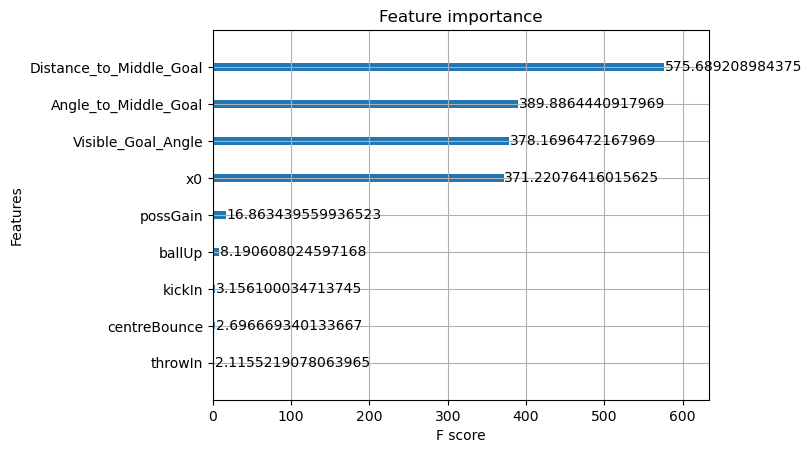

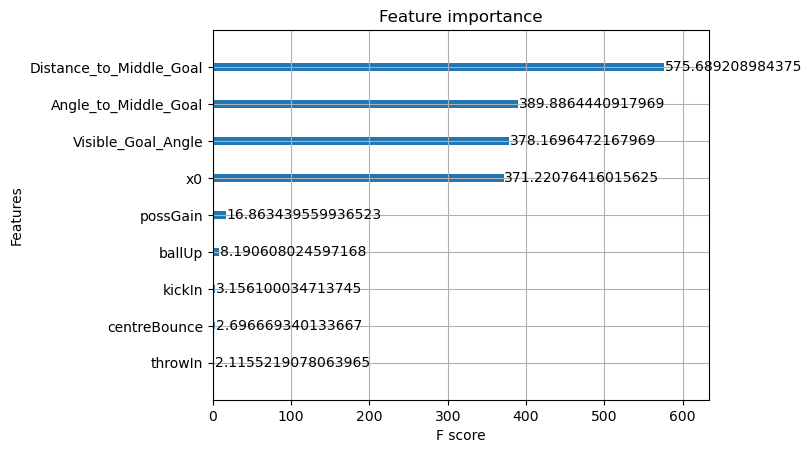

In [68]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

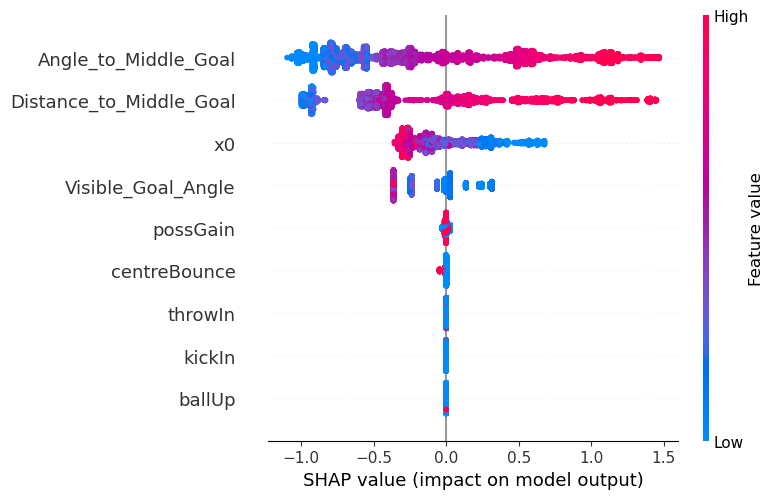

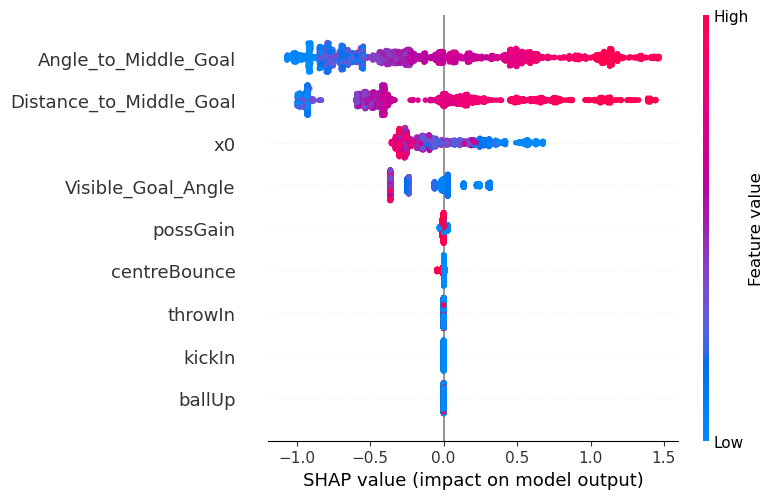

In [69]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [70]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Angle_to_Middle_Goal',
 'Distance_to_Middle_Goal',
 'x0',
 'Visible_Goal_Angle',
 'possGain',
 'centreBounce',
 'ballUp',
 'kickIn',
 'throwIn']

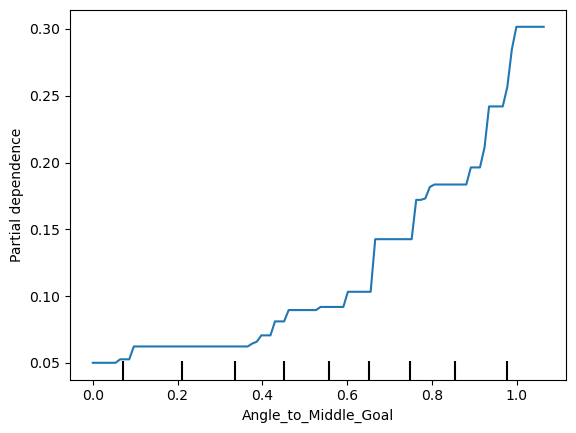

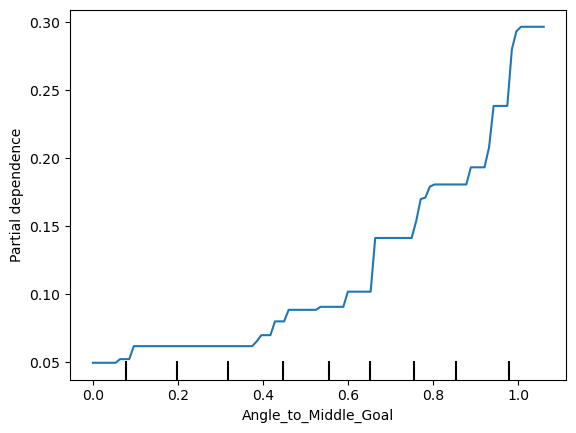

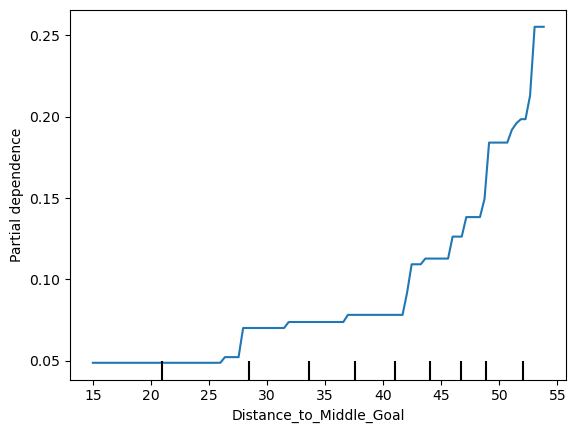

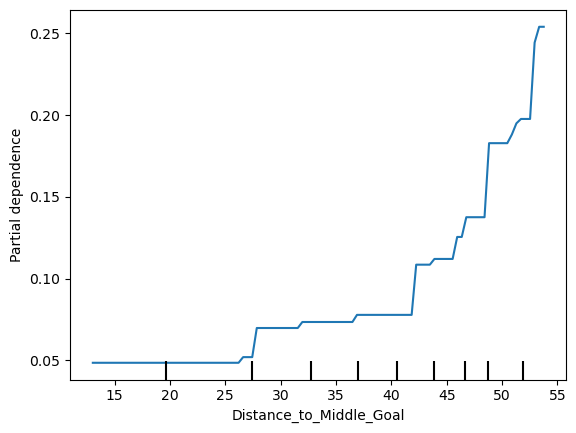

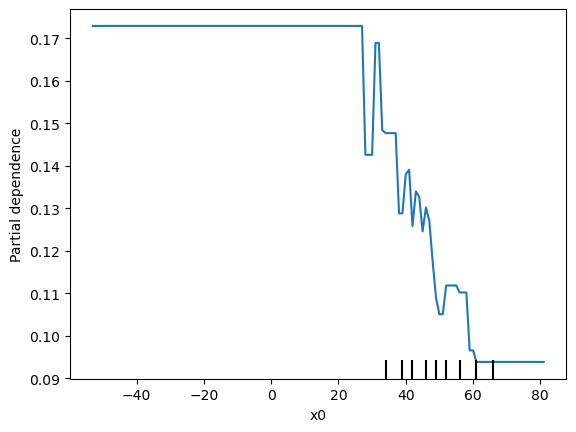

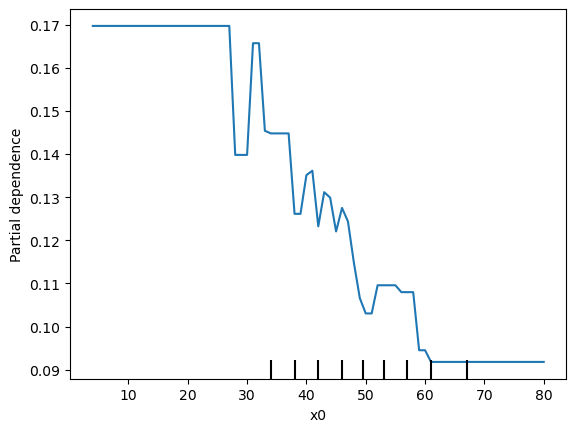

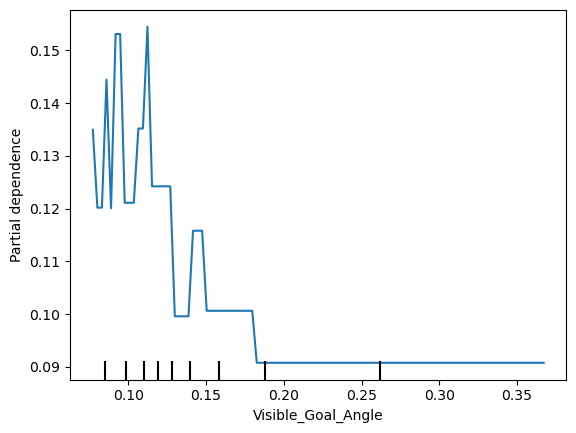

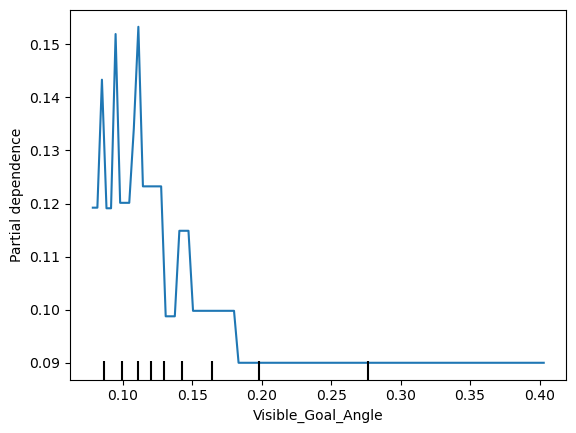

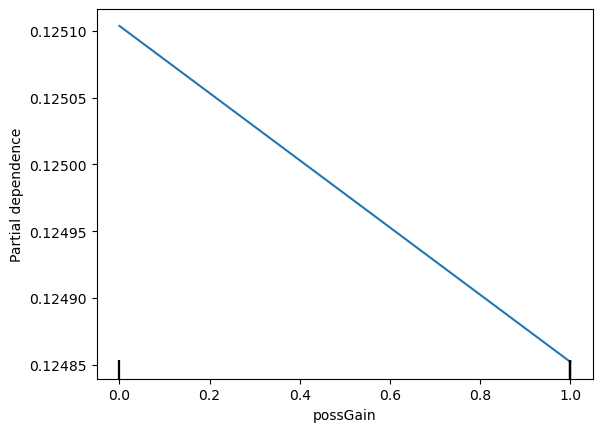

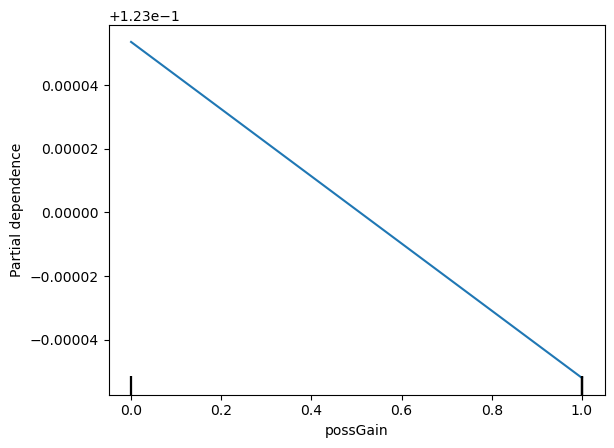

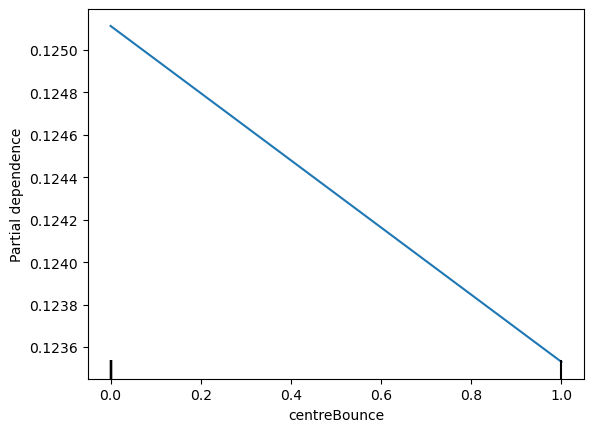

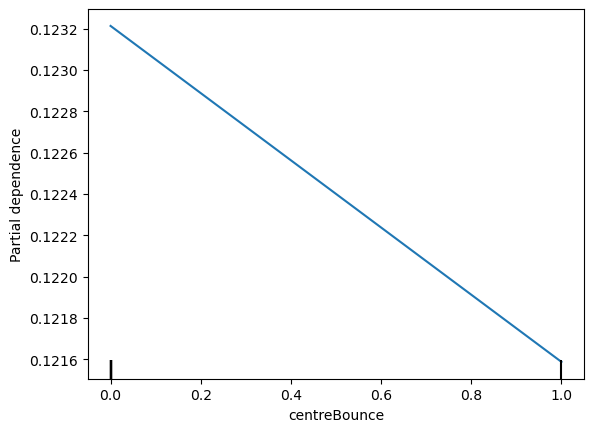

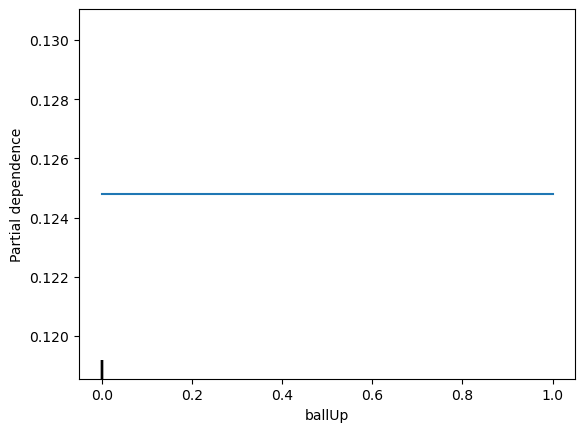

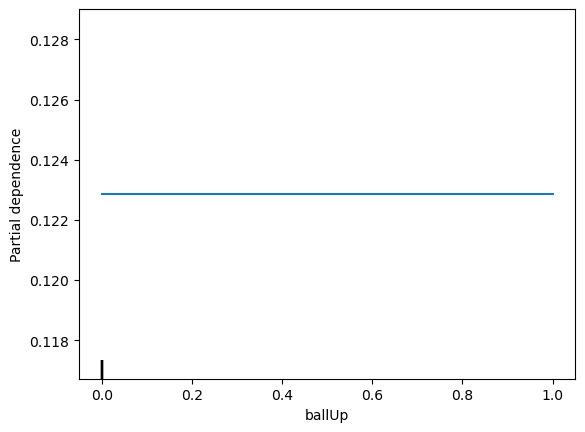

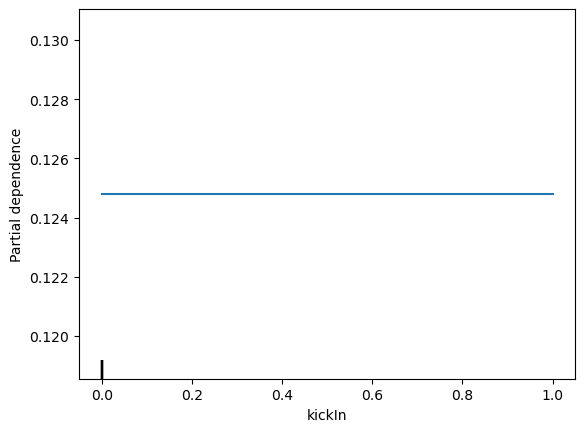

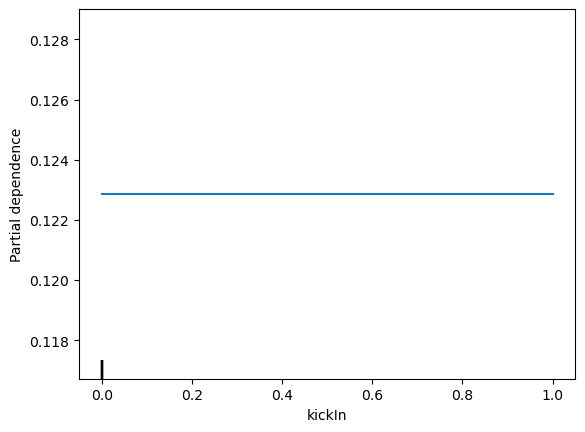

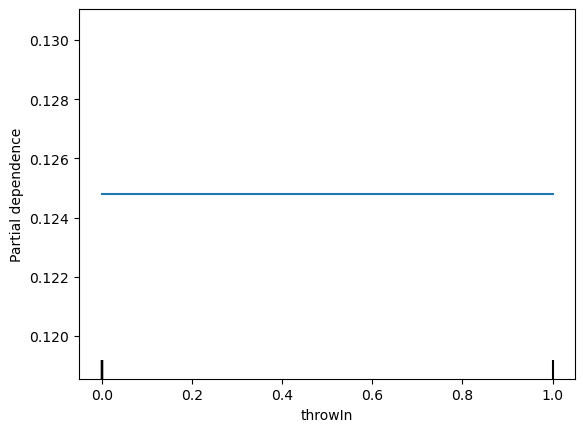

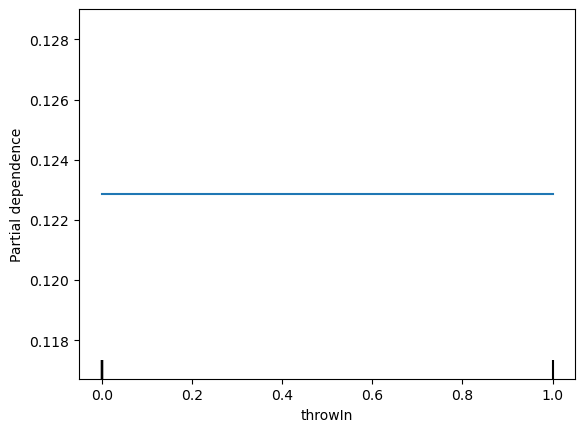

In [71]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

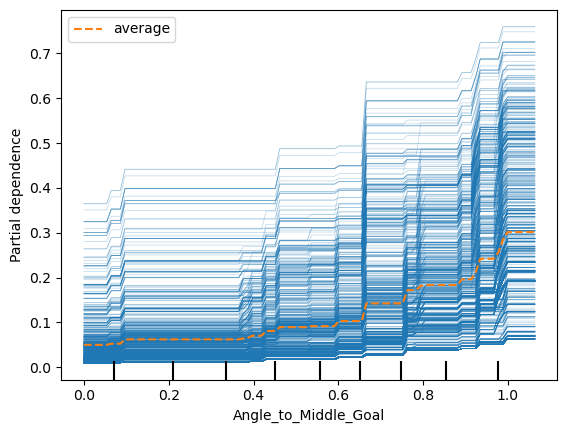

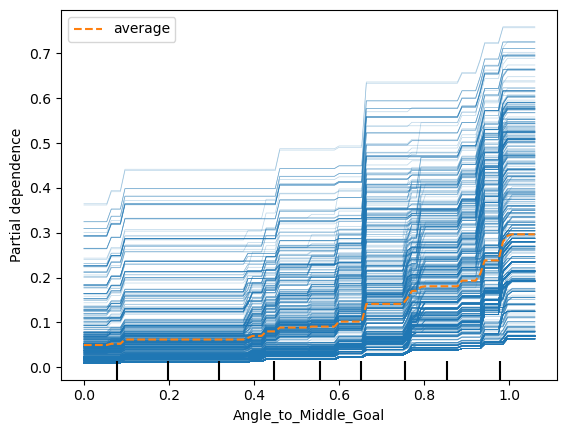

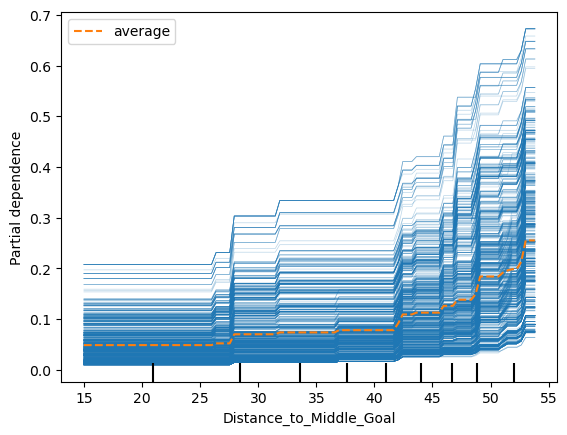

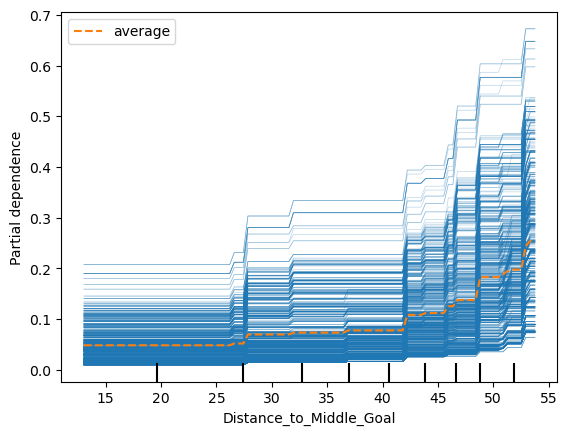

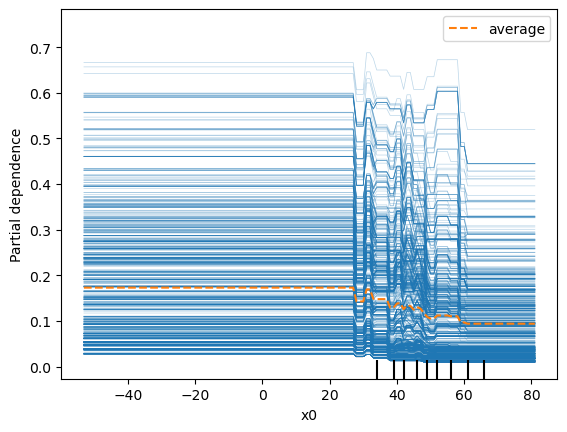

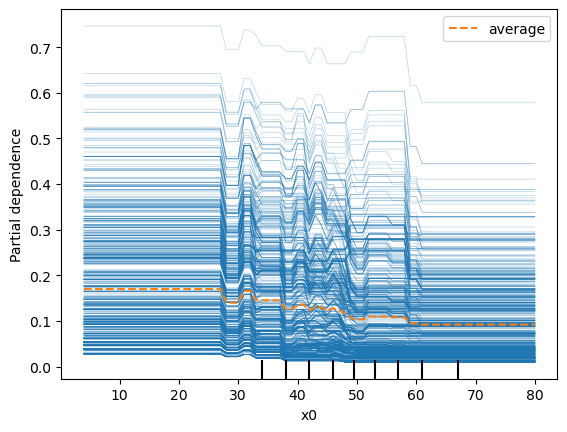

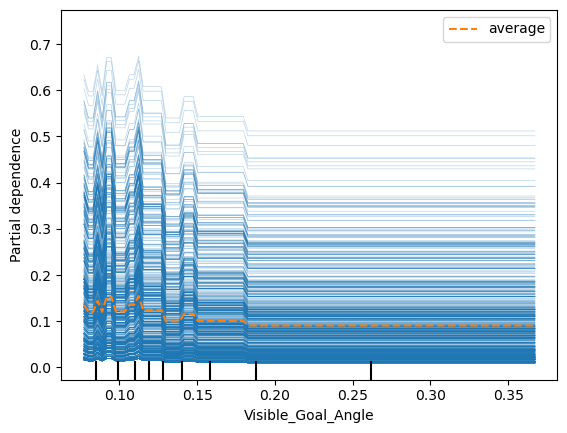

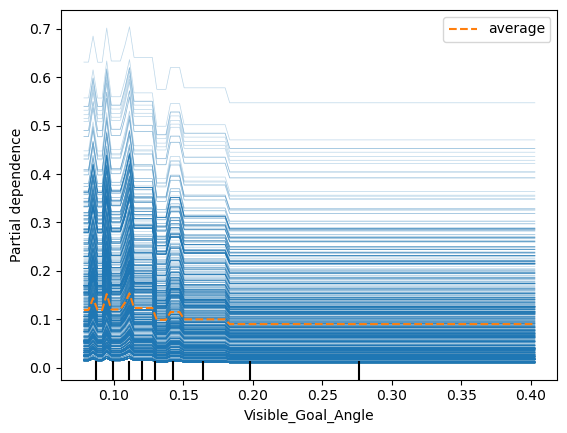

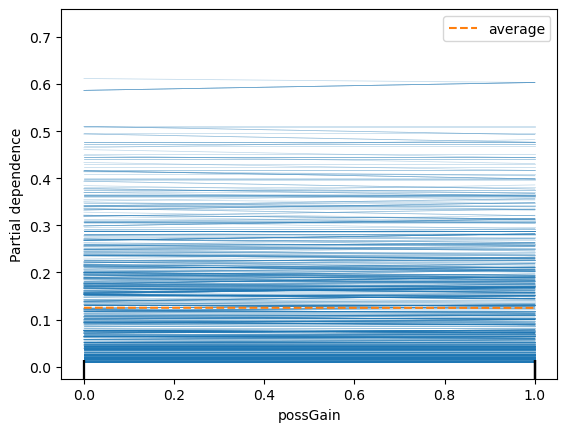

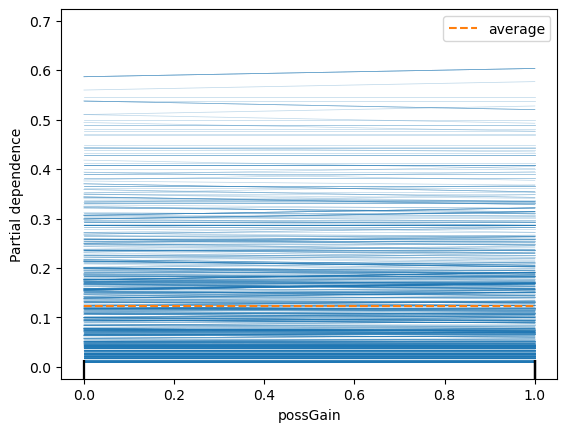

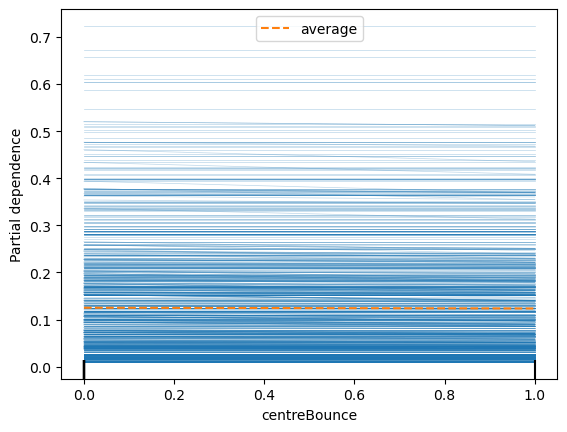

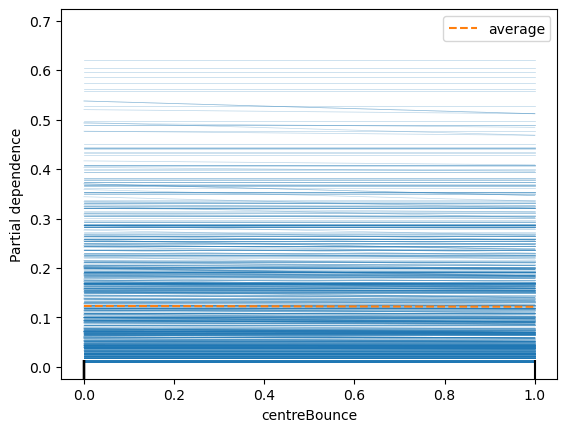

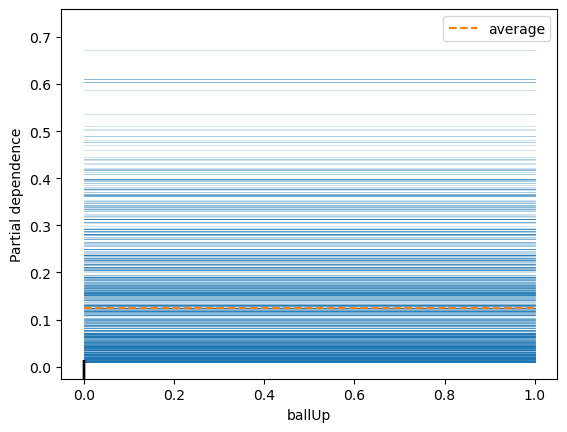

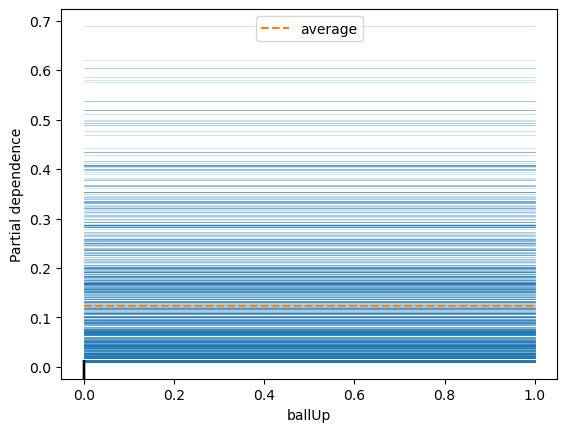

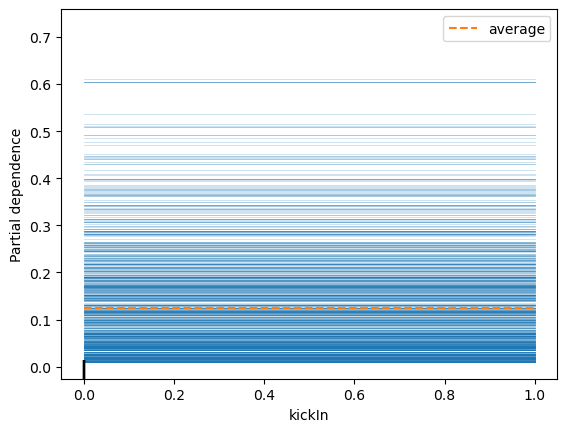

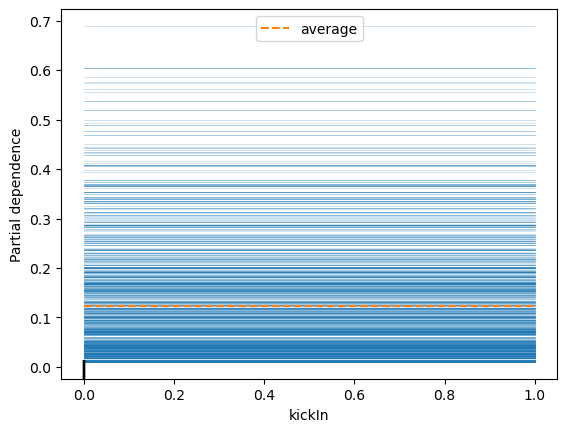

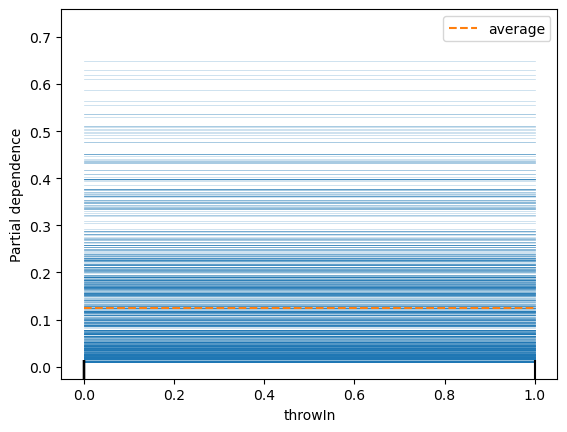

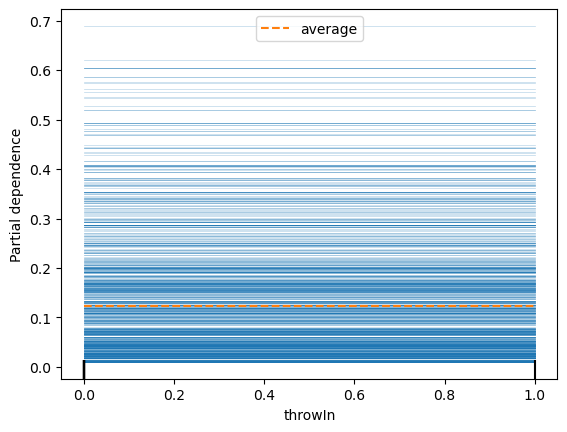

In [72]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

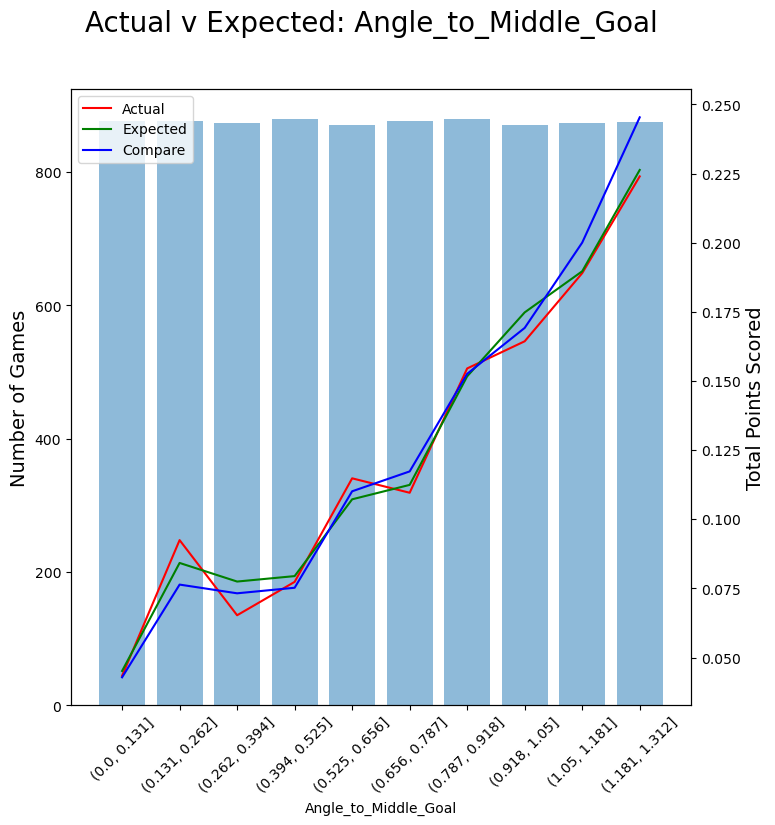

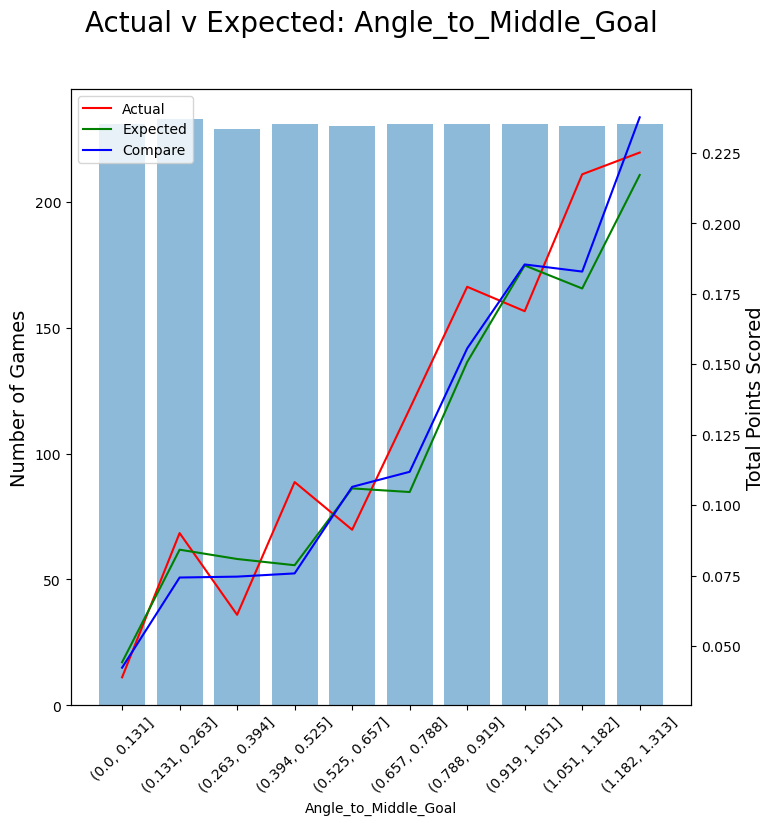

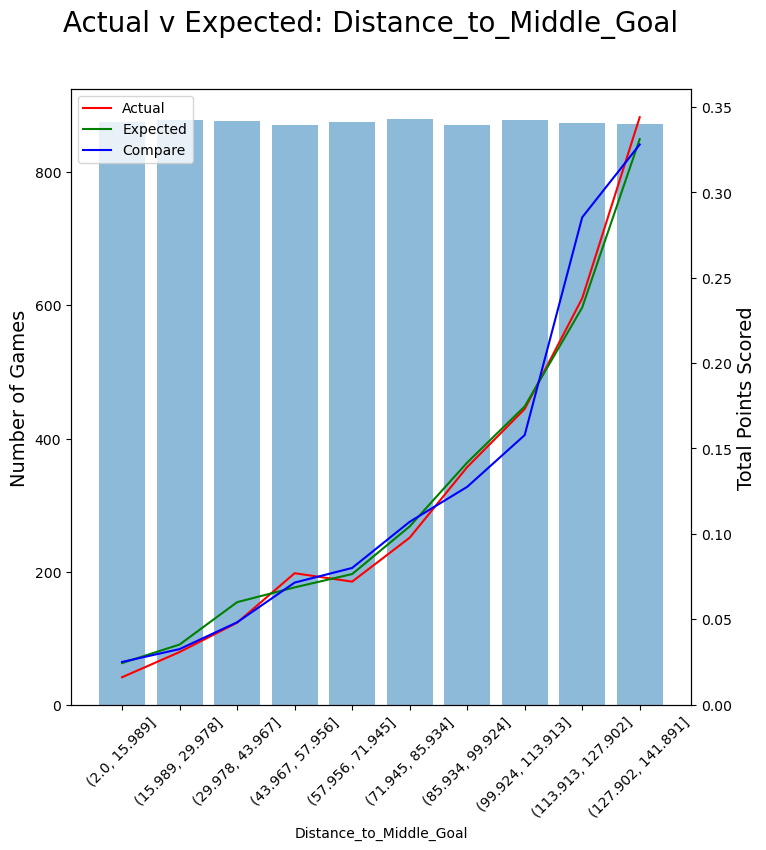

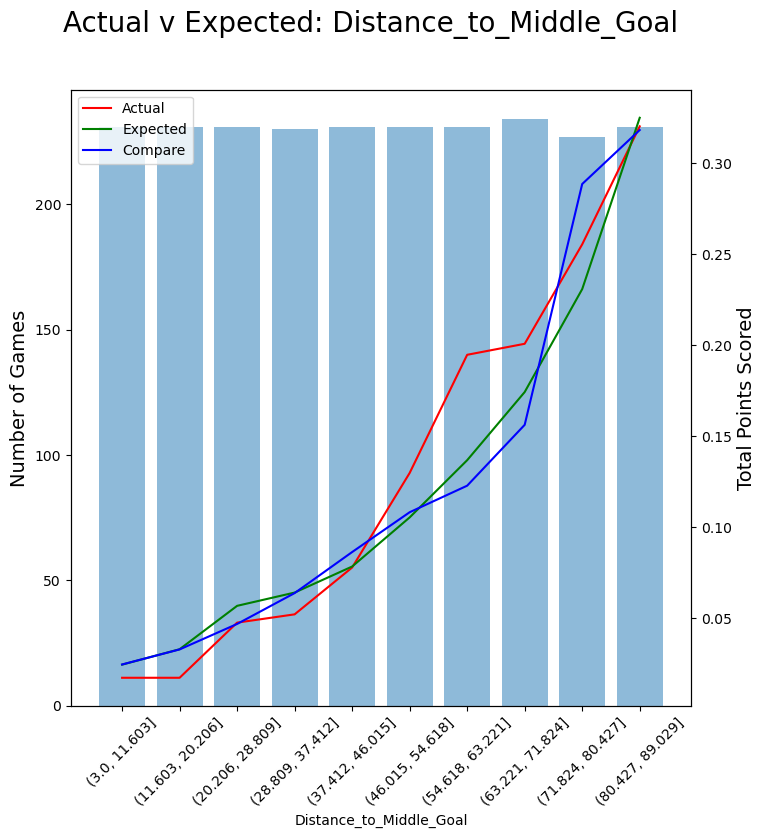

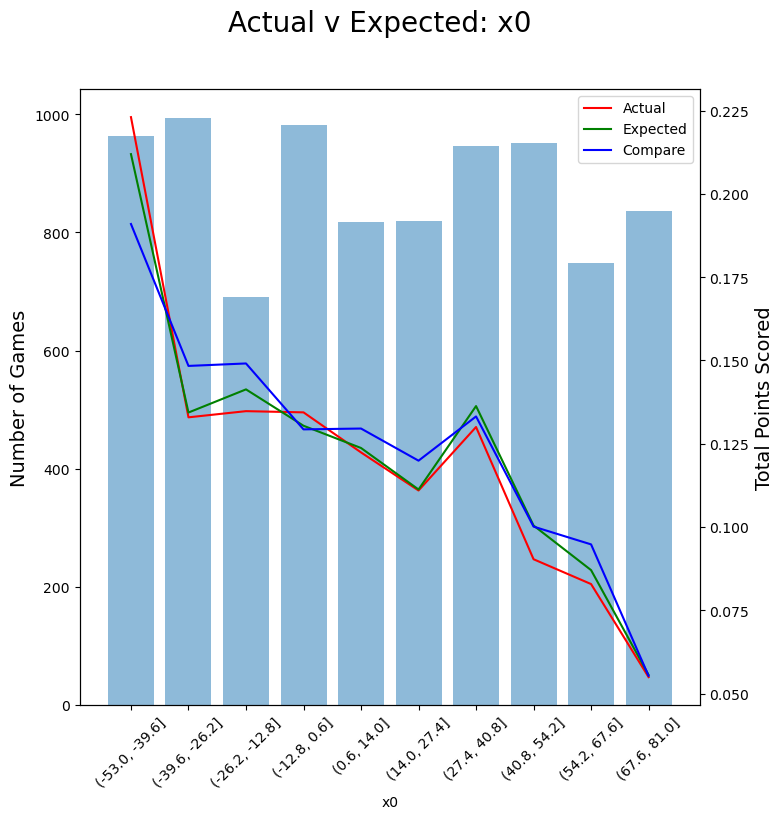

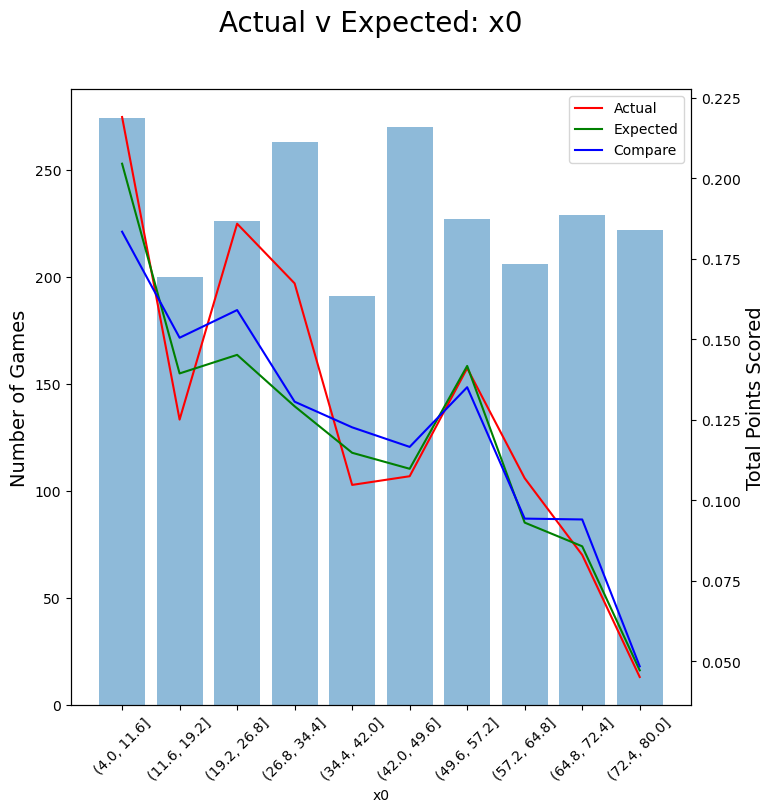

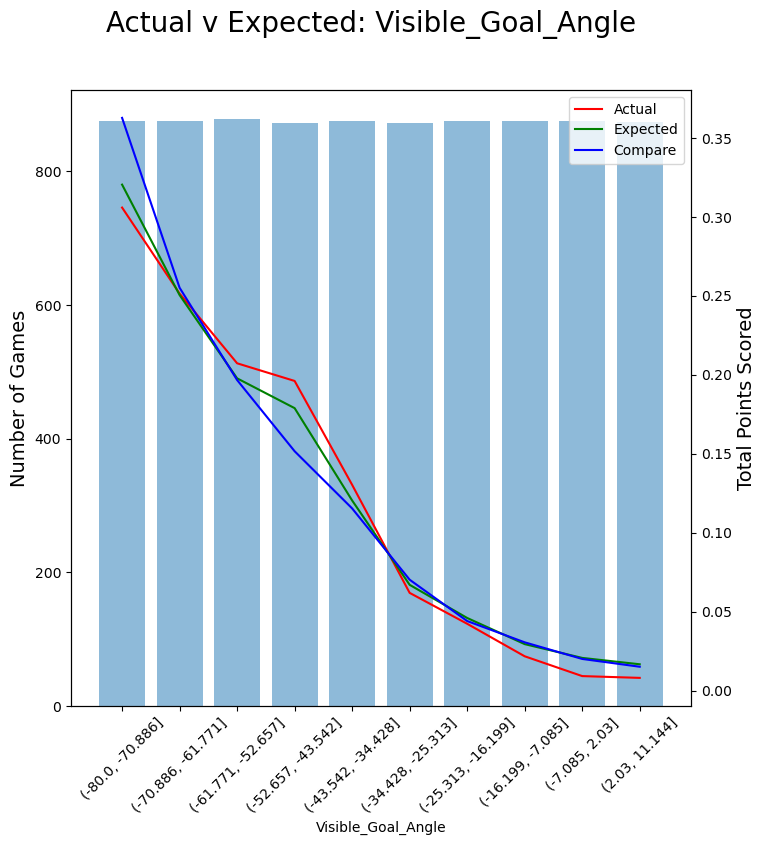

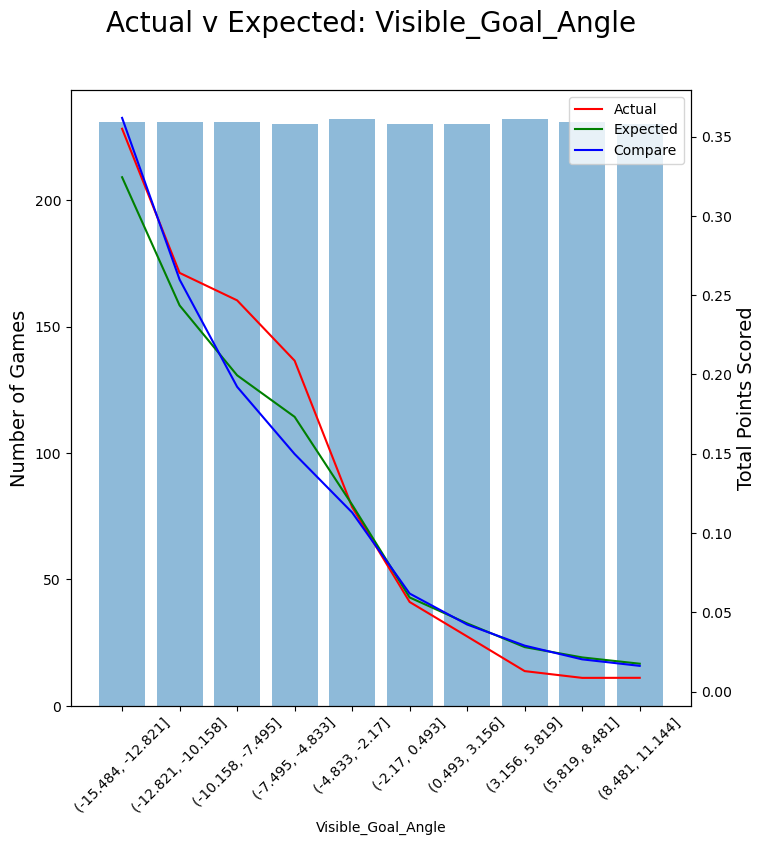

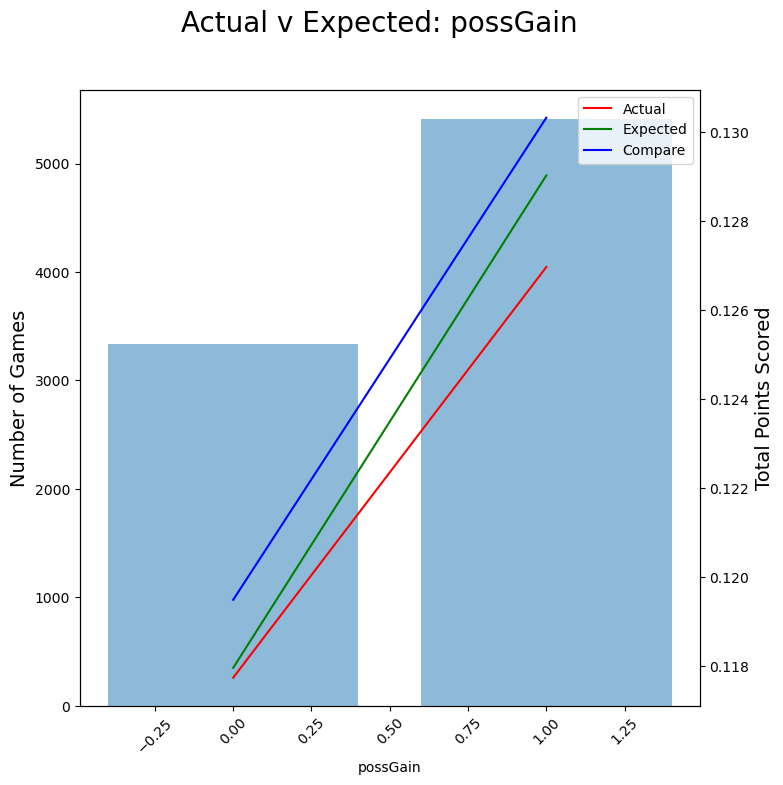

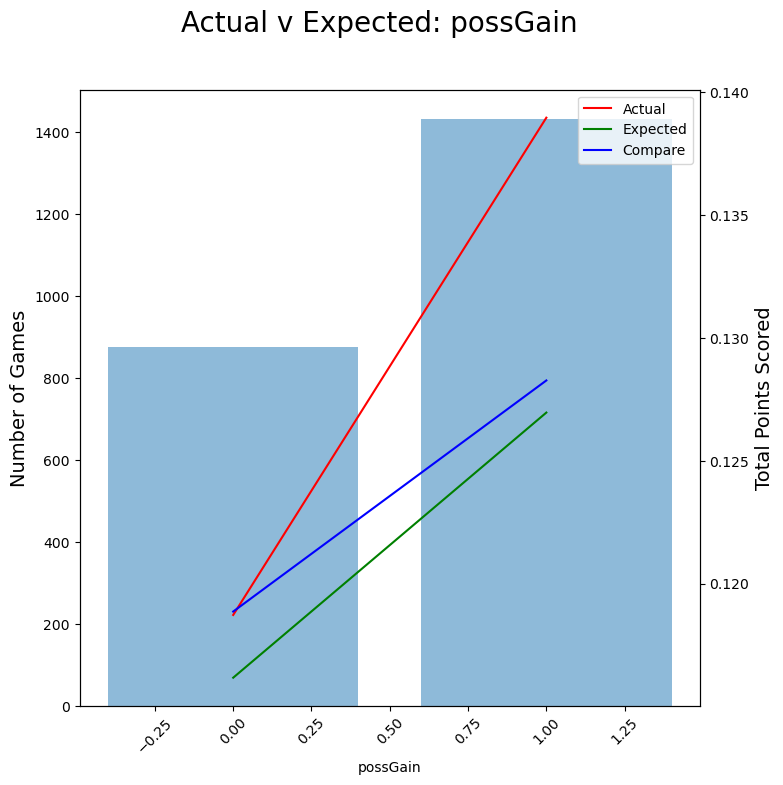

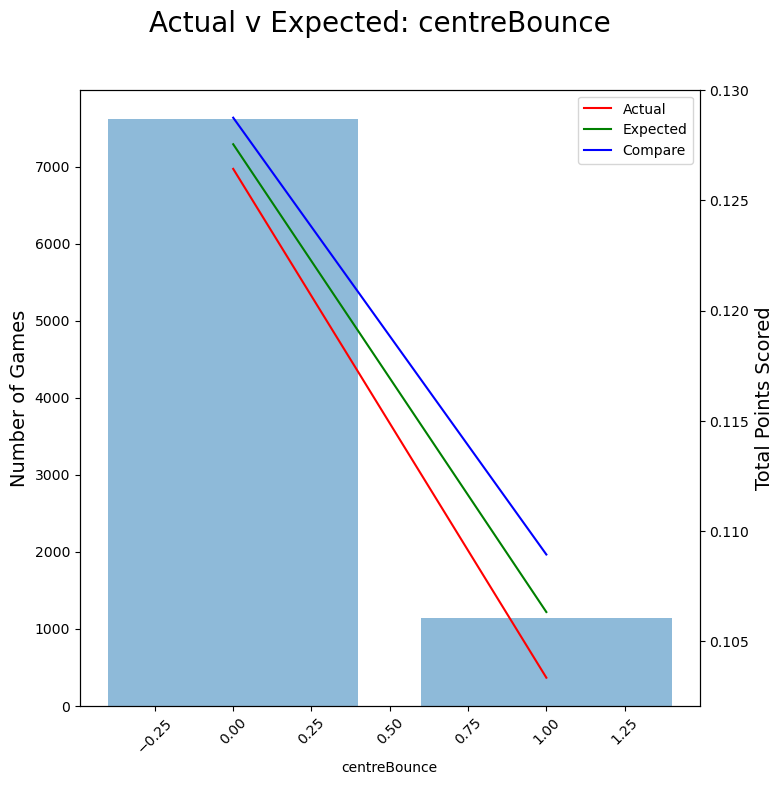

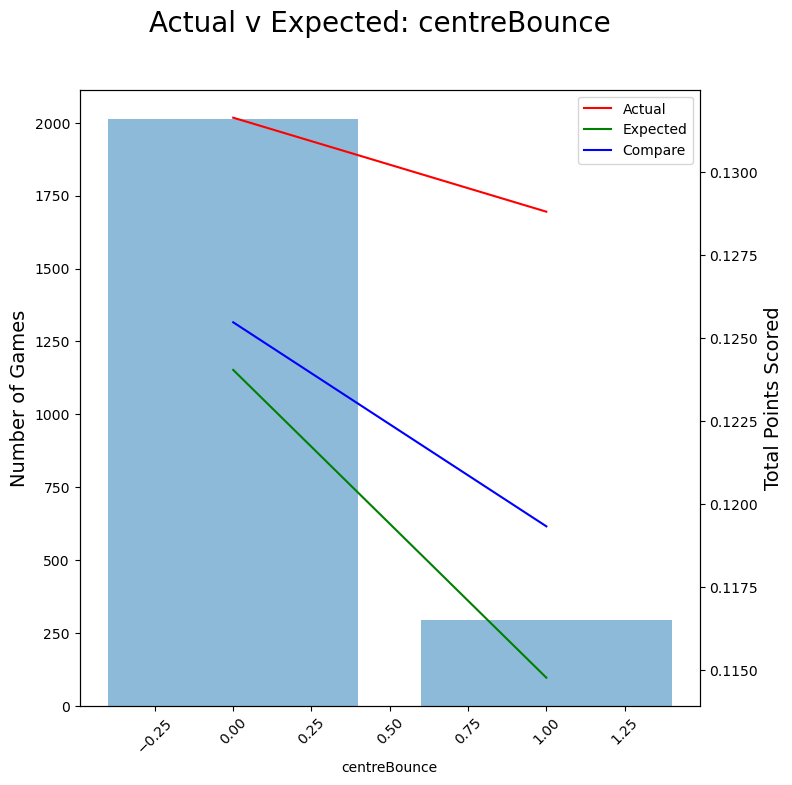

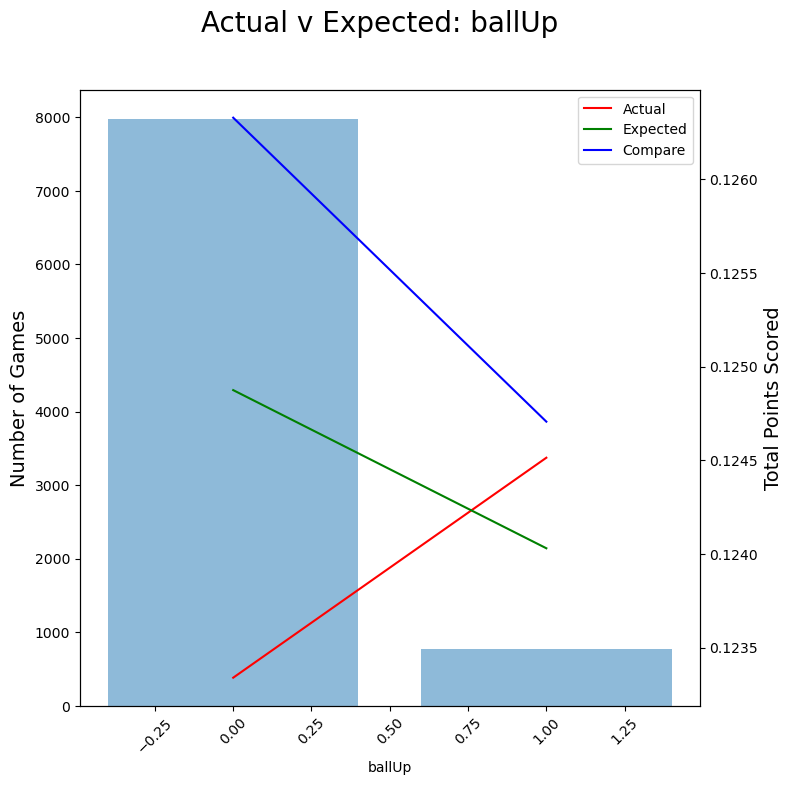

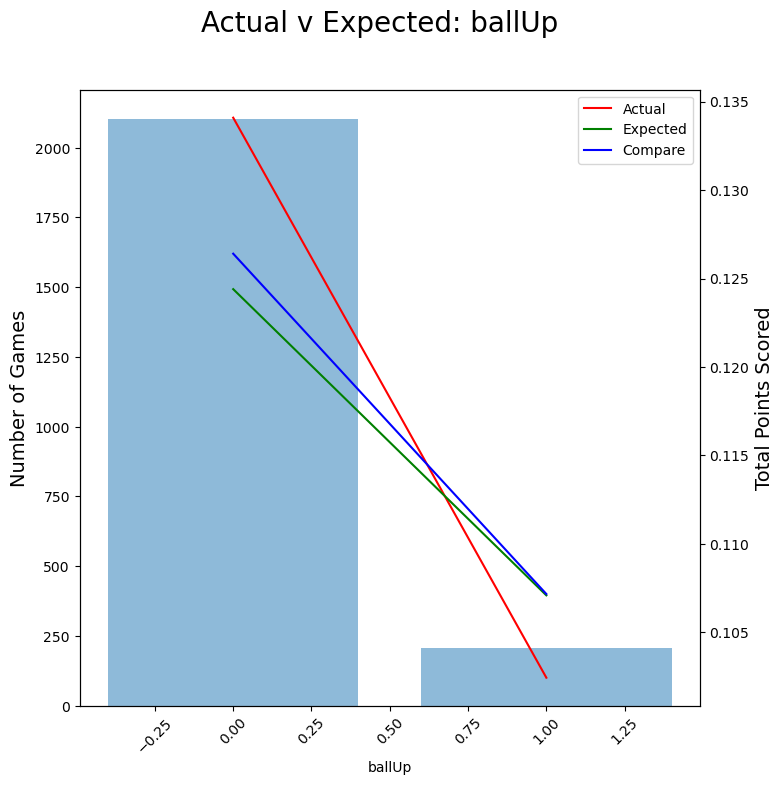

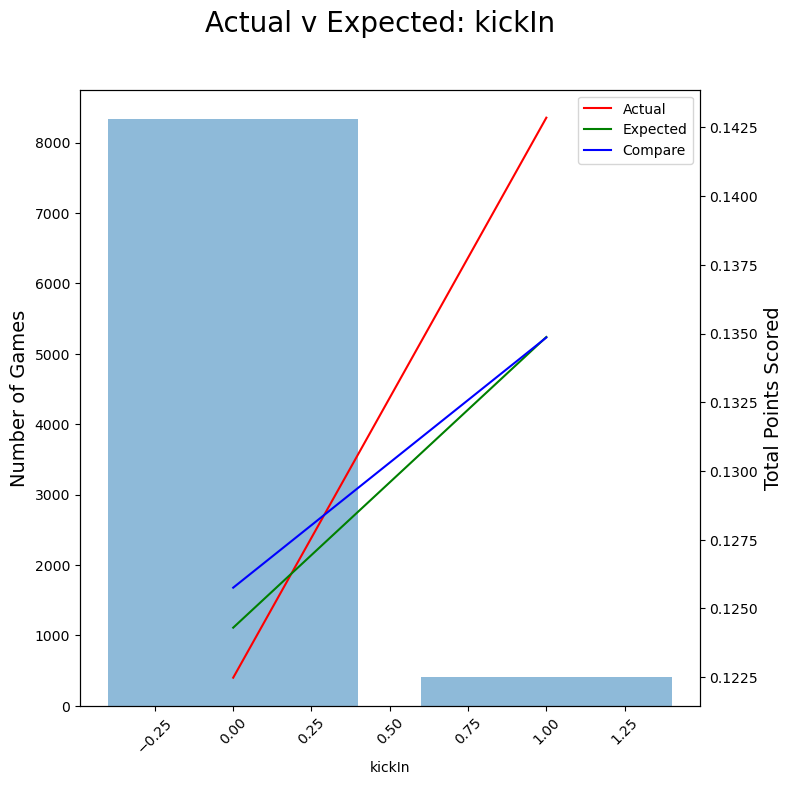

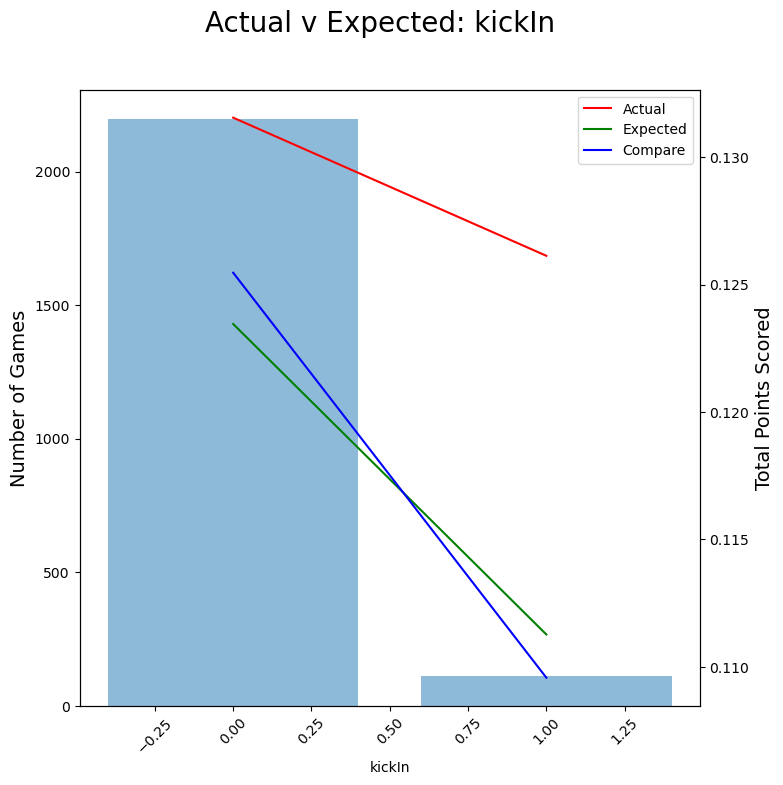

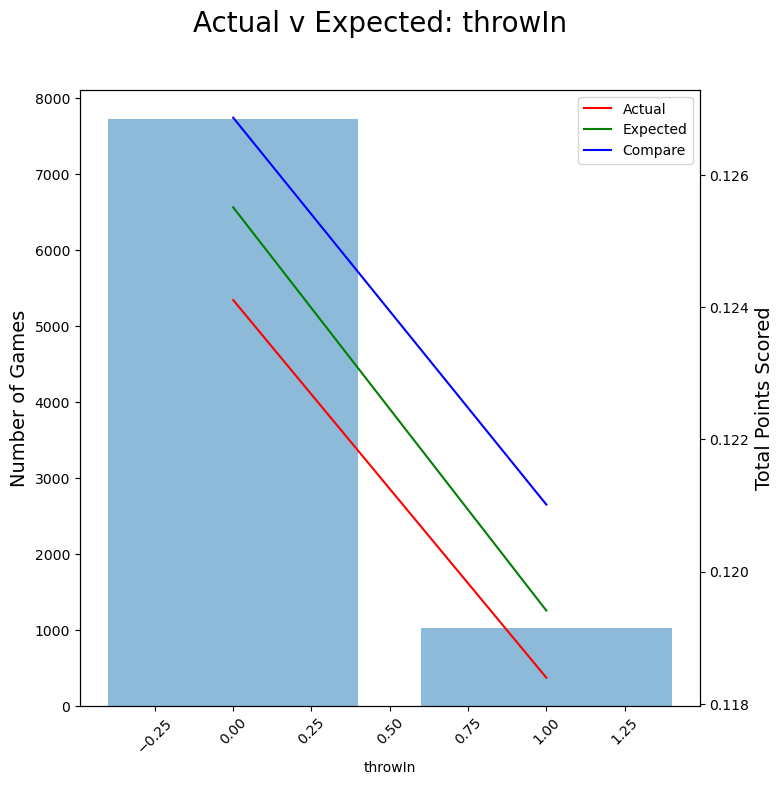

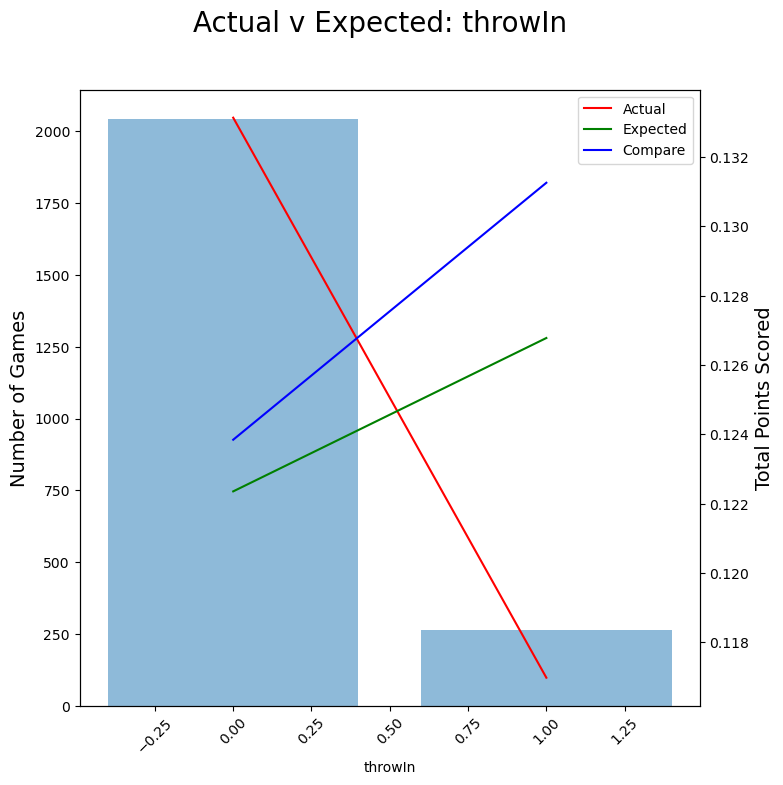

In [73]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [74]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.3028
Compare Log-Loss: 	0.3095
Expected Log-Loss: 	0.3184
Compare Log-Loss: 	0.3233


((0.3027870090707512, 0.3027870090707512),
 (0.3183822993586547, 0.3183822993586547))

In [75]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.0923
Compare Brier Score: 	0.0947
Expected Brier Score: 	0.0986
Compare Brier Score: 	0.1001


((0.09226371067079914, 0.09469227299040944),
 (0.09861250466504673, 0.10009823502473521))

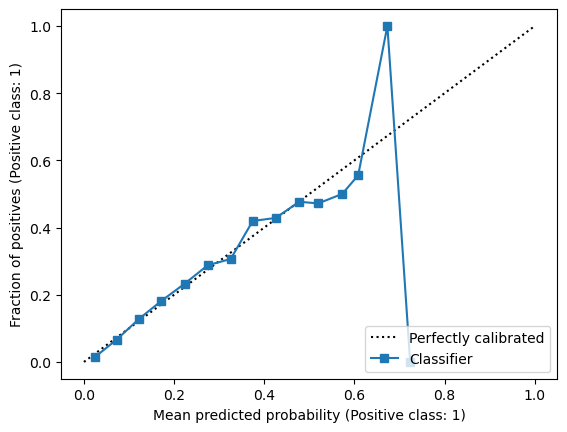

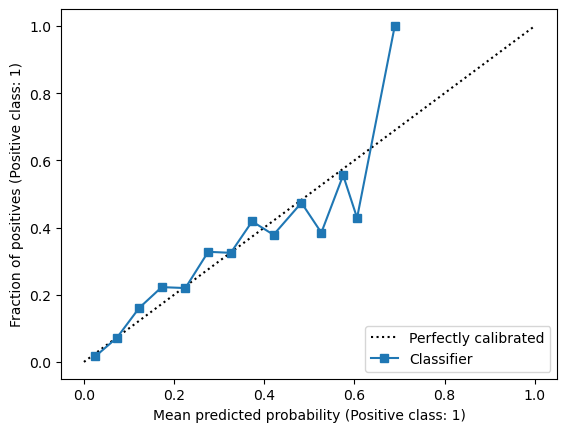

In [76]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)